In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder


# Load the dataset
data_m1 = pd.read_excel('data/M2.xlsx')

# Features (X) and target (y)
X_m1 = data_m1.drop('WPR', axis=1)
y_m1 = data_m1['WPR']

# Split data into training and testing sets
X_train_m1, X_test_m1, y_train_m1, y_test_m1 = train_test_split(X_m1, y_m1, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_m1 = scaler.fit_transform(X_train_m1)
X_test_m1 = scaler.transform(X_test_m1)



In [14]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # You can choose 'median', 'most_frequent', or 'constant'
X_train_m1 = imputer.fit_transform(X_train_m1)
X_test_m1 = imputer.transform(X_test_m1)


In [15]:
import numpy as np

print(np.isnan(X_train_m1).sum())  # Count NaNs in training features
print(np.isnan(X_test_m1).sum())   # Count NaNs in testing features
print(np.isnan(y_train_m1).sum())  # Count NaNs in training labels
print(np.isnan(y_test_m1).sum())   # Count NaNs in testing labels


0
0
0
0


In [16]:
from numpy.linalg import inv

class ELM:
    def __init__(self, n_hidden):
        self.n_hidden = n_hidden
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def fit(self, X, y, reg=1e-6):
        self.input_weights = np.random.rand(X.shape[1], self.n_hidden) * 2 - 1
        self.biases = np.random.rand(1, self.n_hidden)
        H = self.sigmoid(np.dot(X, self.input_weights) + self.biases)
        
        # Regularization added to the pseudo-inverse calculation
        H_T_H = np.dot(H.T, H) + reg * np.identity(H.shape[1])
        self.output_weights = np.dot(inv(H_T_H), np.dot(H.T, y))
        
        return self
    
    def predict(self, X):
        H = self.sigmoid(np.dot(X, self.input_weights) + self.biases)
        return np.dot(H, self.output_weights)

# Train the ELM model with regularization
elm = ELM(n_hidden=20)
elm.fit(X_train_m1, y_train_m1)


# Predict and evaluate the model
y_train_pred_elm = elm.predict(X_train_m1)
y_test_pred_elm = elm.predict(X_test_m1)

mse_train_elm = mean_squared_error(y_train_m1, y_train_pred_elm)
mse_test_elm = mean_squared_error(y_test_m1, y_test_pred_elm)

print("ELM MSE (Train):", mse_train_elm)
print("ELM MSE (Test):", mse_test_elm)


ELM MSE (Train): 0.4439200853166348
ELM MSE (Test): 0.39980961288530514


In [17]:
# Save the predictions
results_train_elm = pd.DataFrame({'GroundTruth': y_train_m1, 'Predictions': y_train_pred_elm})
results_test_elm = pd.DataFrame({'GroundTruth': y_test_m1, 'Predictions': y_test_pred_elm})

results_train_elm.to_excel('outputs/M2elm_train_predictions.xlsx', index=False)
results_test_elm.to_csv('outputs/M2elm_pso_test_predictions.xlsx', index=False)

In [18]:
# PSO Optimization
from pyswarm import pso

def pso_objective(params):
    n_hidden = int(params[0])
    elm = ELM(n_hidden=n_hidden)
    elm.fit(X_train_m1, y_train_m1)
    y_pred = elm.predict(X_test_m1)
    return mean_squared_error(y_test_m1, y_pred)

lb = [10]  # lower bound
ub = [100]  # upper bound

best_params_pso, best_mse_pso = pso(pso_objective, lb, ub, swarmsize=50, maxiter=100)
best_n_hidden_pso = int(best_params_pso[0])

print("Best n_hidden from PSO:", best_n_hidden_pso)
print("Best MSE from PSO:", best_mse_pso)

Stopping search: Swarm best position change less than 1e-08
Best n_hidden from PSO: 100
Best MSE from PSO: 0.3278589455859316


In [20]:
# Train with PSO optimized parameters
elm_pso = ELM(n_hidden=best_n_hidden_pso)
elm_pso.fit(X_train_m1, y_train_m1)

y_train_pred_pso = elm_pso.predict(X_train_m1)
y_test_pred_pso = elm_pso.predict(X_test_m1)

mse_train_pso = mean_squared_error(y_train_m1, y_train_pred_pso)
mse_test_pso = mean_squared_error(y_test_m1, y_test_pred_pso)

print("PSO Optimized ELM MSE (Train):", mse_train_pso)
print("PSO Optimized ELM MSE (Test):", mse_test_pso)

# Save the predictions
results_train_pso = pd.DataFrame({'GroundTruth': y_train_m1, 'Predictions': y_train_pred_pso})
results_test_pso = pd.DataFrame({'GroundTruth': y_test_m1, 'Predictions': y_test_pred_pso})

results_train_pso.to_excel('outputs/M2elm_pso_train_predictions.xlsx', index=False)
results_test_pso.to_excel('outputs/M2elm_pso_test_predictions.xlsx', index=False)

PSO Optimized ELM MSE (Train): 0.3499632282361589
PSO Optimized ELM MSE (Test): 0.3310065239145373


 The best solution found:                                                                           
 [93.]

 Objective function:
 0.3265714543126478


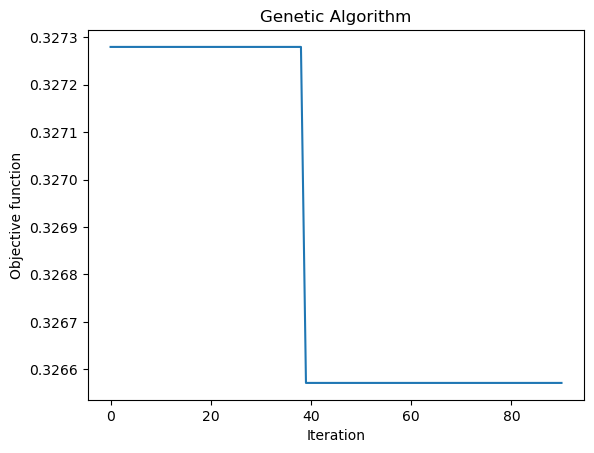

Best n_hidden from GA: 93
Best MSE from GA: 0.3265714543126478


In [21]:
#Optimization using Genetic Algorithm
from geneticalgorithm import geneticalgorithm as ga

# Define the objective function for GA
def ga_objective(params):
    n_hidden = int(params[0])
    elm = ELM(n_hidden=n_hidden)
    elm.fit(X_train_m1, y_train_m1)
    y_pred = elm.predict(X_test_m1)
    return mean_squared_error(y_test_m1, y_pred)

# Define the variable bounds
varbound = np.array([[10, 100]])

# Set up the GA model
model = ga(function=ga_objective, dimension=1, variable_type='int', variable_boundaries=varbound)

# Run the GA optimization
model.run()

best_n_hidden_ga = int(model.output_dict['variable'][0])
best_mse_ga = model.output_dict['function']

print("Best n_hidden from GA:", best_n_hidden_ga)
print("Best MSE from GA:", best_mse_ga)


In [27]:
# Train with GA optimized parameters
elm_ga = ELM(n_hidden=best_n_hidden_ga)
elm_ga.fit(X_train_m1, y_train_m1)

y_train_pred_ga = elm_ga.predict(X_train_m1)
y_test_pred_ga = elm_ga.predict(X_test_m1)

mse_train_ga = mean_squared_error(y_train_m1, y_train_pred_ga)
mse_test_ga = mean_squared_error(y_test_m1, y_test_pred_ga)

print("GA Optimized ELM MSE (Train):", mse_train_ga)
print("GA Optimized ELM MSE (Test):", mse_test_ga)

# Save the predictions
results_train_ga = pd.DataFrame({'GroundTruth': y_train_m1, 'Predictions': y_train_pred_ga})
results_test_ga = pd.DataFrame({'GroundTruth': y_test_m1, 'Predictions': y_test_pred_ga})

results_train_ga.to_excel('outputs/M2elm_ga_train_predictions.xlsx', index=False)
results_test_ga.to_excel('outputs/M2elm_ga_test_predictions.xlsx', index=False)


GA Optimized ELM MSE (Train): 0.3503759530324282
GA Optimized ELM MSE (Test): 0.336217900011469


In [28]:
from niapy.algorithms.basic import HarrisHawksOptimization
from niapy.task import Task
from niapy.problems import Problem

# Define the custom benchmark for HHO
class CustomELMBenchmark(Problem):
    def __init__(self):
        super().__init__(dimension=1, lower=10, upper=100)

    def _evaluate(self, x):
        n_hidden = int(x[0])
        elm = ELM(n_hidden=n_hidden)
        elm.fit(X_train_m1, y_train_m1)
        y_pred = elm.predict(X_test_m1)
        return mean_squared_error(y_test_m1, y_pred)

# Define the task and algorithm
task = Task(problem=CustomELMBenchmark(), max_evals=100)
algo = HarrisHawksOptimization(population_size=30)

# Run the HHO optimization
best_params_hho, best_mse_hho = algo.run(task)
best_n_hidden_hho = int(best_params_hho[0])

print("Best n_hidden from HHO:", best_n_hidden_hho)
print("Best MSE from HHO:", best_mse_hho)


Best n_hidden from HHO: 75
Best MSE from HHO: 0.3292228444096795


In [29]:
# Train with HHO optimized parameters
elm_hho = ELM(n_hidden=best_n_hidden_hho)
elm_hho.fit(X_train_m1, y_train_m1)

y_train_pred_hho = elm_hho.predict(X_train_m1)
y_test_pred_hho = elm_hho.predict(X_test_m1)

mse_train_hho = mean_squared_error(y_train_m1, y_train_pred_hho)
mse_test_hho = mean_squared_error(y_test_m1, y_test_pred_hho)

print("HHO Optimized ELM MSE (Train):", mse_train_hho)
print("HHO Optimized ELM MSE (Test):", mse_test_hho)

# Save the predictions
results_train_hho = pd.DataFrame({'GroundTruth': y_train_m1, 'Predictions': y_train_pred_hho})
results_test_hho = pd.DataFrame({'GroundTruth': y_test_m1, 'Predictions': y_test_pred_hho})

results_train_hho.to_excel('outputs/M2elm_hho_train_predictions.xlsx', index=False)
results_test_hho.to_excel('outputs/M2elm_hho_test_predictions.xlsx', index=False)

HHO Optimized ELM MSE (Train): 0.35589313006747525
HHO Optimized ELM MSE (Test): 0.33480196711488824


In [30]:
import optuna

# Define the objective function for Optuna
def bbo_objective(trial):
    n_hidden = trial.suggest_int("n_hidden", 10, 100)
    elm = ELM(n_hidden=n_hidden)
    elm.fit(X_train_m1, y_train_m1)
    y_pred = elm.predict(X_test_m1)
    return mean_squared_error(y_test_m1, y_pred)

# Create a study object and optimize the objective function
study = optuna.create_study(direction="minimize")
study.optimize(bbo_objective, n_trials=100)

# Best parameters and the corresponding MSE
best_n_hidden_bbo = study.best_params['n_hidden']
best_mse_bbo = study.best_value

print("Best n_hidden from BBO (Optuna):", best_n_hidden_bbo)
print("Best MSE from BBO (Optuna):", best_mse_bbo)


[I 2024-08-31 23:32:48,278] A new study created in memory with name: no-name-bf857b8f-57a0-4e6e-ae93-484bb7c26a1d


[I 2024-08-31 23:32:48,605] Trial 0 finished with value: 0.33216407697002964 and parameters: {'n_hidden': 97}. Best is trial 0 with value: 0.33216407697002964.
[I 2024-08-31 23:32:48,696] Trial 1 finished with value: 0.34190703326441246 and parameters: {'n_hidden': 47}. Best is trial 0 with value: 0.33216407697002964.
[I 2024-08-31 23:32:48,953] Trial 2 finished with value: 0.33264966759723263 and parameters: {'n_hidden': 96}. Best is trial 0 with value: 0.33216407697002964.
[I 2024-08-31 23:32:49,212] Trial 3 finished with value: 0.32850992872018436 and parameters: {'n_hidden': 96}. Best is trial 3 with value: 0.32850992872018436.
[I 2024-08-31 23:32:49,283] Trial 4 finished with value: 0.36628638381064865 and parameters: {'n_hidden': 28}. Best is trial 3 with value: 0.32850992872018436.
[I 2024-08-31 23:32:49,385] Trial 5 finished with value: 0.3525539076310679 and parameters: {'n_hidden': 48}. Best is trial 3 with value: 0.32850992872018436.
[I 2024-08-31 23:32:49,515] Trial 6 finis

Best n_hidden from BBO (Optuna): 88
Best MSE from BBO (Optuna): 0.3284836615164045


In [31]:
# Train with BBO optimized parameters
elm_bbo = ELM(n_hidden=best_n_hidden_bbo)
elm_bbo.fit(X_train_m1, y_train_m1)

y_train_pred_bbo = elm_bbo.predict(X_train_m1)
y_test_pred_bbo = elm_bbo.predict(X_test_m1)

mse_train_bbo = mean_squared_error(y_train_m1, y_train_pred_bbo)
mse_test_bbo = mean_squared_error(y_test_m1, y_test_pred_bbo)

print("BBO (Optuna) Optimized ELM MSE (Train):", mse_train_bbo)
print("BBO (Optuna) Optimized ELM MSE (Test):", mse_test_bbo)

# Save the predictions
results_train_bbo = pd.DataFrame({'GroundTruth': y_train_m1, 'Predictions': y_train_pred_bbo})
results_test_bbo = pd.DataFrame({'GroundTruth': y_test_m1, 'Predictions': y_test_pred_bbo})

results_train_bbo.to_excel('outputs/M2elm_bbo_train_predictions.xlsx', index=False)
results_test_bbo.to_excel('outputs/M2elm_bbo_test_predictions.xlsx', index=False)

BBO (Optuna) Optimized ELM MSE (Train): 0.3525671539463645
BBO (Optuna) Optimized ELM MSE (Test): 0.3381661555456773
